# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [ ]:
df.info()

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [15]:
def bivariada(df, variavel_resposta, variavel_explicativa):
    # Calculando número de saudáveis, número de doentes e total para cada categoria da variável explicativa
    bivariada_data = df.groupby(variavel_explicativa).agg(
        N_saudaveis=('flag_doente', lambda x: (x == 0).sum()),
        N_doentes=('flag_doente', lambda x: (x == 1).sum()),
        Total=('flag_doente', 'count')
    ).reset_index()
    
    # Calculando a proporção de doentes em relação ao total para cada categoria da variável explicativa
    bivariada_data['Proporcao_doentes'] = bivariada_data['N_doentes'] / bivariada_data['Total']
    
    return bivariada_data

# Exemplo de uso da função para a variável 'sex' (sexo)
resultado_bivariada_sex = bivariada(df, 'flag_doente', 'sex')
print(resultado_bivariada_sex)

# Exemplo de uso da função para a variável 'cp' (tipo de dor no peito)
resultado_bivariada_cp = bivariada(df, 'flag_doente', 'cp')
print(resultado_bivariada_cp)

# Exemplo de uso da função para a variável 'fbs' (açúcar no sangue em jejum)
resultado_bivariada_fbs = bivariada(df, 'flag_doente', 'fbs')
print(resultado_bivariada_fbs)




   sex  N_saudaveis  N_doentes  Total  Proporcao_doentes
0  0.0           72         25     97           0.257732
1  1.0           92        114    206           0.553398
    cp  N_saudaveis  N_doentes  Total  Proporcao_doentes
0  1.0           16          7     23           0.304348
1  2.0           41          9     50           0.180000
2  3.0           68         18     86           0.209302
3  4.0           39        105    144           0.729167
   fbs  N_saudaveis  N_doentes  Total  Proporcao_doentes
0  0.0          141        117    258           0.453488
1  1.0           23         22     45           0.488889


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [21]:
import pandas as pd
import numpy as np

def categorizar_variavel_quantitativa(df, variavel_resposta, variavel_explicativa, num_categorias=5):
    # Criando os rótulos para as categorias
    categorias_labels = [f'Grupo_{i+1}' for i in range(num_categorias)]
    
    # Criando os intervalos para categorização
    intervalos = pd.qcut(df[variavel_explicativa], q=num_categorias, labels=categorias_labels, duplicates='drop')
    
    # Adicionando os intervalos ao dataframe
    df['Categoria'] = intervalos
    
    # Calculando o número de saudáveis, número de doentes e total para cada categoria da variável explicativa
    bivariada_data = df.groupby('Categoria').agg(
        N_saudaveis=('flag_doente', lambda x: (x == 0).sum()),
        N_doentes=('flag_doente', lambda x: (x == 1).sum()),
        Total=('flag_doente', 'count')
    ).reset_index()
    
    # Calculando a proporção de doentes em relação ao total para cada categoria da variável explicativa
    bivariada_data['Proporcao_doentes'] = bivariada_data['N_doentes'] / bivariada_data['Total']
    
    return bivariada_data

# Exemplo de uso da função para a variável 'age' (idade)
resultado_bivariada_age = categorizar_variavel_quantitativa(df, 'flag_doente', 'age', num_categorias=5)
print(resultado_bivariada_age)


  Categoria  N_saudaveis  N_doentes  Total  Proporcao_doentes
0   Grupo_1           47         16     63           0.253968
1   Grupo_2           42         22     64           0.343750
2   Grupo_3           32         39     71           0.549296
3   Grupo_4           13         32     45           0.711111
4   Grupo_5           30         30     60           0.500000


C:\Users\Cliente\AppData\Local\Temp\ipykernel_672\2369187240.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada_data = df.groupby('Categoria').agg(


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# 1. Preparar os dados
# Selecionar as variáveis relevantes
X = df[['sex', 'cp', 'age', 'trestbps']]
y = df['flag_doente']

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Construir o pipeline do modelo
# Escalonar as variáveis numéricas e aplicar regressão logística
numeric_features = ['age', 'trestbps']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# 3. Treinar o modelo
model.fit(X_train, y_train)

# 4. Avaliar o modelo
# Prever os rótulos das classes no conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# Mostrar um relatório de classificação
print(classification_report(y_test, y_pred))


Acurácia do modelo: 0.5081967213114754
              precision    recall  f1-score   support

           0       0.49      0.72      0.58        29
           1       0.56      0.31      0.40        32

    accuracy                           0.51        61
   macro avg       0.52      0.52      0.49        61
weighted avg       0.52      0.51      0.49        61



4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

C:\Users\Cliente\AppData\Local\Temp\ipykernel_672\3666444859.py:12: RuntimeWarning: Mean of empty slice.
  prob_mean = [y_prob[groups == i].mean() for i in range(1, 6)]
C:\Users\Cliente\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


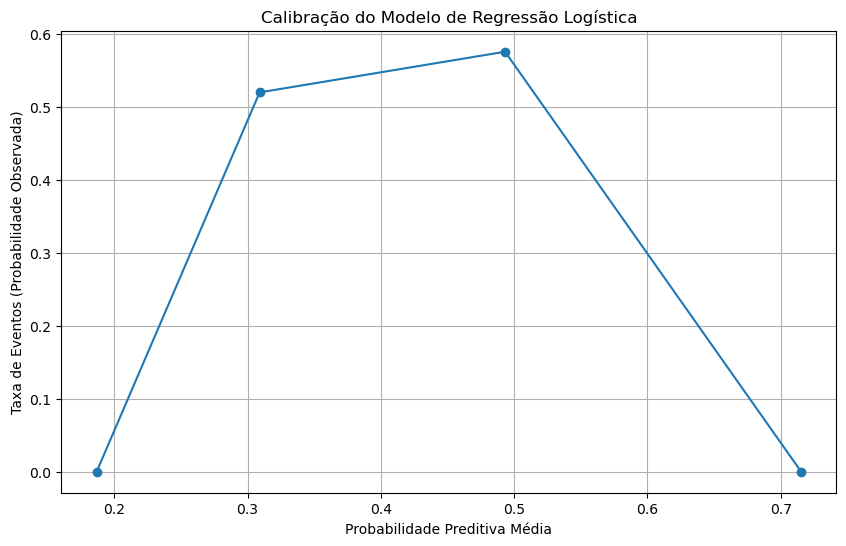

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Calcular a probabilidade de evento predita segundo o modelo
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Categorizar essa probabilidade em 5 grupos (G = 5)
bins = np.linspace(0, 1, 6)
groups = np.digitize(y_prob, bins)

# 3. Calcular a probabilidade de evento predita média por grupo
prob_mean = [y_prob[groups == i].mean() for i in range(1, 6)]

# 4. Calcular a taxa de eventos (média da variável indicadora de eventos) por grupo
event_rate = [y_test.iloc[groups == i].mean() for i in range(1, 6)]

# 5. Comparar graficamente o valor esperado versus observado para a taxa de maus por grupo
plt.figure(figsize=(10, 6))
plt.plot(prob_mean, event_rate, marker='o', linestyle='-')
plt.xlabel('Probabilidade Preditiva Média')
plt.ylabel('Taxa de Eventos (Probabilidade Observada)')
plt.title('Calibração do Modelo de Regressão Logística')
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. Calcular a acurácia do modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

# 2. Calcular o índice de Gini
y_prob = model.predict_proba(X_test)[:, 1]
gini_index = 2 * roc_auc_score(y_test, y_prob) - 1
print("Índice de Gini:", gini_index)

# 3. Calcular o KS (Kolmogorov-Smirnov)
from scipy.stats import ks_2samp
ks_statistic, ks_p_value = ks_2samp(y_prob[y_test == 0], y_prob[y_test == 1])
print("KS (Kolmogorov-Smirnov) Estatística:", ks_statistic)
print("KS (Kolmogorov-Smirnov) Valor-p:", ks_p_value)

Acurácia do modelo: 0.5081967213114754
Índice de Gini: 0.18318965517241392
KS (Kolmogorov-Smirnov) Estatística: 0.19827586206896552
KS (Kolmogorov-Smirnov) Valor-p: 0.507544725895456


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Definir as variáveis preditoras (X) e a variável de resposta (y)
X = df[['age', 'sex', 'cp', 'trestbps']]
y = df['flag_doente']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar as variáveis preditoras (X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Fazer previsões usando o conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
gini = 2 * roc_auc_score(y_test, y_pred) - 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ks_statistic = np.max(tpr - fpr)

# Calcular KS (Kolmogorov-Smirnov) Valor-p, evitando divisão por zero
if np.any(tpr * (1 - tpr) + fpr * (1 - fpr) == 0):
    ks_p_value = np.nan
else:
    ks_p_value = ks_statistic / np.sqrt(tpr * (1 - tpr) + fpr * (1 - fpr))

print("Acurácia do modelo:", accuracy)
print("Índice de Gini:", gini)
print("KS (Kolmogorov-Smirnov) Estatística:", ks_statistic)
print("KS (Kolmogorov-Smirnov) Valor-p:", ks_p_value)



Acurácia do modelo: 0.7377049180327869
Índice de Gini: 0.4773706896551724
KS (Kolmogorov-Smirnov) Estatística: 0.4773706896551724
KS (Kolmogorov-Smirnov) Valor-p: nan
